In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
!pip install -q findspark
import findspark
findspark.init()

In [2]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SQLContext 
sc = SparkContext("local", "App Name")

In [3]:
sql = SQLContext(sc)
df = pd.read_excel("btc17-21_day.xlsx",sheet_name="Day")
df=sql.createDataFrame(df) 
df.show()

/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+----------+------------------+---------------+---------------+------------+-------------+---------+--------------+--------------+-------------+-------------+----------+----------+-----------+-----------+----------+--------+--------+
|      time|num_not_empty_hour|      nBits_day|      value_day|in_count_day|out_count_day|count_day|volume_btc_day|volume_usd_day|value_min_day|value_max_day|in_min_day|in_max_day|out_min_day|out_max_day| Next_time|    Open|   Close|
+----------+------------------+---------------+---------------+------------+-------------+---------+--------------+--------------+-------------+-------------+----------+----------+-----------+-----------+----------+--------+--------+
|1605744000|                24|120357045062433|237845975128673|      854333|       900212|   311061|       648.258| 1.157131272E7|            0|1738730017046|         1|      1026|          1|       3678|1605830400|17801.21|17824.13|
|1605657600|                24|140069288055771|293015947122925| 

# 3 Regression Model

## Data Processing

In [4]:
# Features engineering
from pyspark.sql import functions as F
df = (df
    .withColumn('time', df['time']+0)
    .withColumn('nBits', df['nBits_day']/df['count_day'])
    .withColumn('value', df['value_day']+0)
    .withColumn('in_count', df['in_count_day']+0)
    .withColumn('out_count', df['out_count_day']+0)
    .withColumn('count', df['count_day']+0)
    .withColumn('value_max', df['value_max_day']+0)
    .withColumn('in_max', df['in_max_day']+0)
    .withColumn('out_max', df['out_max_day']+0)
    .withColumn('Open', df['Open']+0)
    # .withColumn('value', df['value']/df['count'])
    .withColumn('Volume BTC', F.round(df['volume_btc_day'], 5))
    .withColumn('Close', df['Close']+0)
    )
df = (df
    .select(
        F.col('time'), F.col('nBits'), F.col('value'), F.col('in_count'), F.col('out_count'), F.col('count'), F.col('value_max'), 
        F.col('in_max'), F.col('out_max'), F.col('Open'), F.col('Volume BTC'), F.col('Close').alias('Target'),
    )
    )
df.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|  Target|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|
|1605484800| 3.869549543175676E8|361830361786069|  920102|   869288|311477|1900338360044|   984|   3641| 15975.9|   563.242|16722.99|
|1605398400|        3.86974771E8|159894568491318|  856957|   7

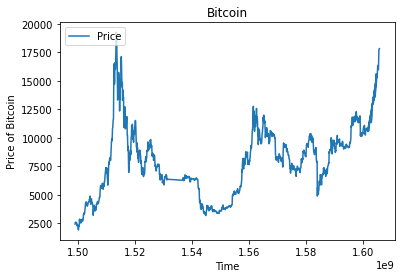

In [5]:
import matplotlib.pyplot as plt

y = [val.Target for val in df.select('Target').collect()]
x = [val.time for val in df.select('time').collect()]

plt.plot(x, y)

plt.ylabel('Price of Bitcoin')
plt.xlabel('Time')
plt.title('Bitcoin')
plt.legend(['Price'], loc='upper left')

plt.show()

In [6]:
# Feature aggregation
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC'], outputCol="features")
df = assembler.transform(df)
df.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+--------------------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|  Target|            features|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+--------------------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|[1.605744E9,3.869...|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|[1.6056576E9,3.86...|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|[1.6055712E9,3.86...|
|1605484800| 3.869549543175676E8|361830361786069|  920102|   869288|31

In [8]:
# Split data into training set and testing set
# 2020-10-20(1603234800)
# 2020-08-01(1596240000)
# 2020-07-01(1593561600)
X_train = df.filter(F.col('time') < "1593561600")
X_test = df.filter(F.col('time') > "1593561600")
X_test.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+--------------------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|  Target|            features|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+--------------------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|[1.605744E9,3.869...|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|[1.6056576E9,3.86...|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|[1.6055712E9,3.86...|
|1605484800| 3.869549543175676E8|361830361786069|  920102|   869288|31

## Linear Regression Model

In [9]:
from pyspark.ml.regression import *
# Applying Linear Regression Model
lr = LinearRegression(featuresCol = 'features', labelCol="Target")
fitted_lr = lr.fit(X_train)
yhat_lr = (fitted_lr.transform(X_test))
yhat_lr = (yhat_lr
          .withColumn('Residual', F.round(F.col('Target')-F.col('prediction'),2))
          .withColumn('prediction', F.round('prediction',2))
)
yhat_lr = yhat_lr.sort('time')
yhat_lr.select(F.col('time'), F.col('Target'), F.col('prediction'), F.col('Residual')).show()

+----------+-------+----------+--------+
|      time| Target|prediction|Residual|
+----------+-------+----------+--------+
|1593648000|9092.32|   9267.93| -175.61|
|1593734400|9066.15|   9148.19|  -82.04|
|1593820800|9132.58|   9077.95|   54.63|
|1593907200|9084.94|    9084.5|    0.44|
|1593993600| 9349.0|    9107.3|   241.7|
|1594080000|9260.85|   9407.82| -146.97|
|1594166400|9442.36|   9266.36|   176.0|
|1594252800|9242.54|   9476.19| -233.65|
|1594339200| 9287.0|   9282.24|    4.76|
|1594425600|9241.42|   9312.75|  -71.33|
|1594512000|9300.25|   9188.76|  111.49|
|1594598400|9239.26|   9301.85|  -62.59|
|1594684800|9256.87|   9273.97|   -17.1|
|1594771200|9193.02|   9299.78| -106.76|
|1594857600|9134.65|   9223.52|  -88.87|
|1594944000|9159.97|    9118.7|   41.27|
|1595030400|9179.16|   9149.19|   29.97|
|1595116800| 9217.8|   9166.23|   51.57|
|1595203200|9166.53|   9236.56|  -70.03|
|1595289600|9396.53|   9188.31|  208.22|
+----------+-------+----------+--------+
only showing top

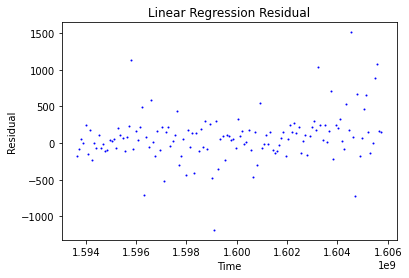

In [ ]:
import matplotlib.pyplot as plt

y = [val.Residual for val in yhat_lr.select('Residual').collect()]
x = [val.time for val in yhat_lr.select('time').collect()]

l=plt.plot(x, y, 'bo')
plt.setp(l, 'markersize', 1)
plt.ylabel('Residual')
plt.xlabel('Time')
plt.title('Linear Regression Residual')

plt.show()

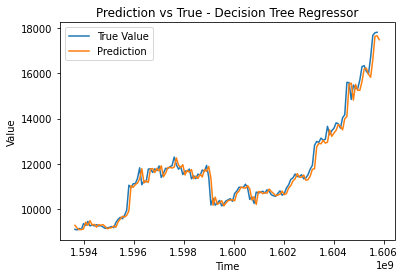

In [ ]:
y_predict = [val.prediction for val in yhat_lr.select('prediction').collect()]
y_true = [val.Target for val in yhat_lr.select('Target').collect()]
x = [val.time for val in yhat_lr.select('time').collect()]

plt.plot(x, y_true, label='True Value')
plt.plot(x, y_predict, label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Prediction vs True - Decision Tree Regressor')
plt.legend()

plt.show()

In [10]:
# Evaluations of Linear Regression Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_lr)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_lr, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_lr, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 336.47492655682163
MAE is 221.96354609929085
R² is 0.9711654712003829


## Decision Tree Regressor

In [ ]:
# Applying Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol="Target")
dt.setSeed(1234567)
fitted_dt = dt.fit(X_train)
yhat_dt = (fitted_dt.transform(X_test))
yhat_dt = (yhat_dt
          .withColumn('Residual', F.round(F.col('Target')-F.col('prediction'),2))
          .withColumn('prediction', F.round('prediction',2))
)
yhat_dt = yhat_dt.sort('time')
yhat_dt.select(F.col('time'), F.col('Target'), F.col('prediction'), F.col('Residual')).show()

+----------+-------+----------+--------+
|      time| Target|prediction|Residual|
+----------+-------+----------+--------+
|1593648000|9092.32|    9322.3| -229.98|
|1593734400|9066.15|   8914.23|  151.92|
|1593820800|9132.58|   8914.23|  218.35|
|1593907200|9084.94|   8914.23|  170.71|
|1593993600| 9349.0|   8914.23|  434.77|
|1594080000|9260.85|    9322.3|  -61.45|
|1594166400|9442.36|    9322.3|  120.06|
|1594252800|9242.54|    9322.3|  -79.76|
|1594339200| 9287.0|    9322.3|   -35.3|
|1594425600|9241.42|    9322.3|  -80.88|
|1594512000|9300.25|    9322.3|  -22.05|
|1594598400|9239.26|    9322.3|  -83.04|
|1594684800|9256.87|    9322.3|  -65.43|
|1594771200|9193.02|    9322.3| -129.28|
|1594857600|9134.65|    9322.3| -187.65|
|1594944000|9159.97|   8914.23|  245.74|
|1595030400|9179.16|   8914.23|  264.93|
|1595116800| 9217.8|    9322.3|  -104.5|
|1595203200|9166.53|    9322.3| -155.77|
|1595289600|9396.53|    9322.3|   74.23|
+----------+-------+----------+--------+
only showing top

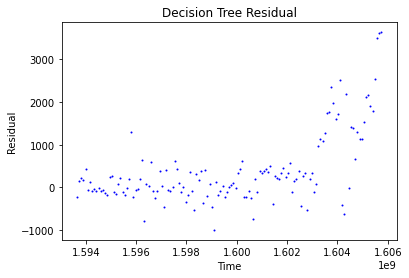

In [ ]:
y = [val.Residual for val in yhat_dt.select('Residual').collect()]
x = [val.time for val in yhat_dt.select('time').collect()]

l=plt.plot(x, y, 'bo')
plt.setp(l, 'markersize', 1)
plt.ylabel('Residual')
plt.xlabel('Time')
plt.title('Decision Tree Residual')

plt.show()

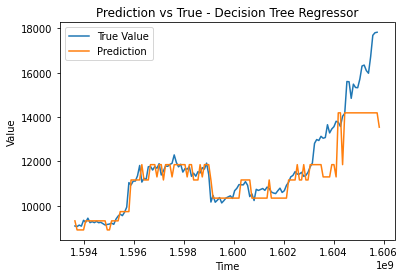

In [ ]:
y_predict = [val.prediction for val in yhat_dt.select('prediction').collect()]
y_true = [val.Target for val in yhat_dt.select('Target').collect()]
x = [val.time for val in yhat_dt.select('time').collect()]

plt.plot(x, y_true, label='True Value')
plt.plot(x, y_predict, label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Prediction vs True - Decision Tree Regressor')
plt.legend()

plt.show()

In [ ]:
# Evaluations of Decision Tree Regressor Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_dt)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_dt, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_dt, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 929.2339942582654
MAE is 562.9553222063105
R² is 0.7800835971044648


In [ ]:
# Importance of each features in Decision Tree Regressor
import pandas as pd
score = fitted_dt.featureImportances.toArray()
features = ['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC']
features_score = (pd.DataFrame(dict(zip(features, score)), range(1))
  .T.rename(columns={0:'Score'})
  .sort_values("Score", ascending =False)
  )
features_score

,Score
Open,0.967507
nBits,0.025293
value,0.003319
time,0.001633
in_count,0.001602
out_count,0.000468
Volume BTC,0.000117
out_max,0.000061
count,0.000000
value_max,0.000000


## Gradient Boosted Tree Regressor

In [12]:
# Applying a gradient boosted tree regressor
gbt = GBTRegressor(labelCol="Target")
gbt.setSeed(1234567)
fitted = gbt.fit(X_train)
yhat_gbt = (fitted.transform(X_test))
yhat_gbt = (yhat_gbt
          .withColumn('Residual', F.round(F.col('Target')-F.col('prediction'),2))
          .withColumn('prediction', F.round('prediction',2))
)
yhat_gbt = yhat_gbt.sort('time')
yhat_gbt.select(F.col('time'), F.col('Target'), F.col('prediction'), F.col('Residual')).show()

+----------+-------+----------+--------+
|      time| Target|prediction|Residual|
+----------+-------+----------+--------+
|1593648000|9092.32|   9248.47| -156.15|
|1593734400|9066.15|   8957.94|  108.21|
|1593820800|9132.58|    8910.7|  221.88|
|1593907200|9084.94|   8945.92|  139.02|
|1593993600| 9349.0|   8874.84|  474.16|
|1594080000|9260.85|   9377.41| -116.56|
|1594166400|9442.36|   9186.53|  255.83|
|1594252800|9242.54|   9289.99|  -47.45|
|1594339200| 9287.0|   9441.48| -154.48|
|1594425600|9241.42|   9338.06|  -96.64|
|1594512000|9300.25|   9396.75|   -96.5|
|1594598400|9239.26|   9452.13| -212.87|
|1594684800|9256.87|   9390.22| -133.35|
|1594771200|9193.02|   9363.53| -170.51|
|1594857600|9134.65|   9303.24| -168.59|
|1594944000|9159.97|   8994.62|  165.35|
|1595030400|9179.16|   8838.79|  340.37|
|1595116800| 9217.8|   9238.36|  -20.56|
|1595203200|9166.53|   9247.96|  -81.43|
|1595289600|9396.53|    9318.2|   78.33|
+----------+-------+----------+--------+
only showing top

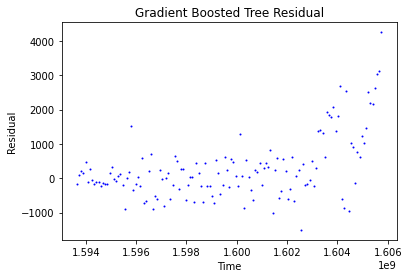

In [ ]:
y = [val.Residual for val in yhat_gbt.select('Residual').collect()]
x = [val.time for val in yhat_gbt.select('time').collect()]

l=plt.plot(x, y, 'bo')
plt.setp(l, 'markersize', 1)
plt.ylabel('Residual')
plt.xlabel('Time')
plt.title('Gradient Boosted Tree Residual')

plt.show()

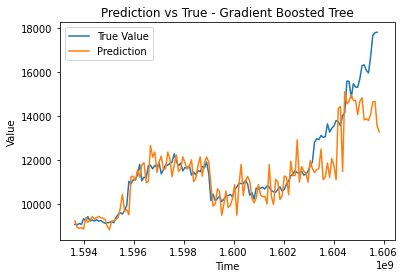

In [ ]:
y_predict = [val.prediction for val in yhat_gbt.select('prediction').collect()]
y_true = [val.Target for val in yhat_gbt.select('Target').collect()]
x = [val.time for val in yhat_gbt.select('time').collect()]

plt.plot(x, y_true, label='True Value')
plt.plot(x, y_predict, label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Prediction vs True - Gradient Boosted Tree')
plt.legend()

plt.show()

In [ ]:
# Evaluations of gradient boosted tree regressor
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_gbt)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_gbt, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_gbt, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 973.8455171816576
MAE is 647.8165836157409
R² is 0.7584608221829989


In [ ]:
# Importance of each features in GBTRegressor
import pandas as pd
score = fitted.featureImportances.toArray()
features = ['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC']
features_score = (pd.DataFrame(dict(zip(features, score)), range(1))
  .T.rename(columns={0:'Score'})
  .sort_values("Score", ascending =False)
  )
features_score

,Score
Open,0.853107
nBits,0.028056
value,0.021070
value_max,0.016264
out_max,0.015659
in_count,0.014424
Volume BTC,0.013303
in_max,0.011498
count,0.009655
out_count,0.009268


In [17]:
# Optimise the model with Kfold and GridSearch Method(GBT)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 8, 10, 12])
             .addGrid(gbt.maxBins, [32, 64])
             .build())
cv = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=eval,
                          numFolds=3)  
cv.setSeed(12345678)
cvModel = cv.fit(X_train)
cvYhat = cvModel.transform(X_test)

cvYhat = cvYhat.sort('time')
cvYhat = (cvYhat
          .withColumn('Residual', F.round(F.col('Target')-F.col('prediction'),2))
          .withColumn('prediction', F.round('prediction',2))
)
cvYhat.select(F.col('time'), F.col('Target'), F.col('prediction'), F.col('Residual')).show()

+----------+-------+----------+--------+
|      time| Target|prediction|Residual|
+----------+-------+----------+--------+
|1593648000|9092.32|   9248.47| -156.15|
|1593734400|9066.15|   8957.94|  108.21|
|1593820800|9132.58|    8910.7|  221.88|
|1593907200|9084.94|   8945.92|  139.02|
|1593993600| 9349.0|   8874.84|  474.16|
|1594080000|9260.85|   9377.41| -116.56|
|1594166400|9442.36|   9186.53|  255.83|
|1594252800|9242.54|   9289.99|  -47.45|
|1594339200| 9287.0|   9441.48| -154.48|
|1594425600|9241.42|   9338.06|  -96.64|
|1594512000|9300.25|   9396.75|   -96.5|
|1594598400|9239.26|   9452.13| -212.87|
|1594684800|9256.87|   9390.22| -133.35|
|1594771200|9193.02|   9363.53| -170.51|
|1594857600|9134.65|   9303.24| -168.59|
|1594944000|9159.97|   8994.62|  165.35|
|1595030400|9179.16|   8838.79|  340.37|
|1595116800| 9217.8|   9238.36|  -20.56|
|1595203200|9166.53|   9247.96|  -81.43|
|1595289600|9396.53|    9318.2|   78.33|
+----------+-------+----------+--------+
only showing top

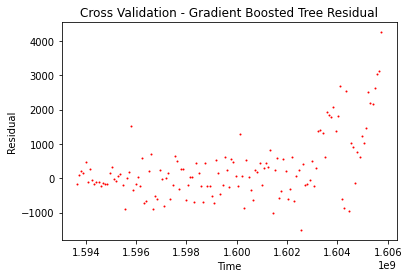

In [15]:
y = [val.Residual for val in cvYhat.select('Residual').collect()]
x = [val.time for val in cvYhat.select('time').collect()]

l=plt.plot(x, y, 'ro')
plt.setp(l, 'markersize', 1)
plt.ylabel('Residual')
plt.xlabel('Time')
plt.title('Cross Validation - Gradient Boosted Tree Residual')

plt.show()

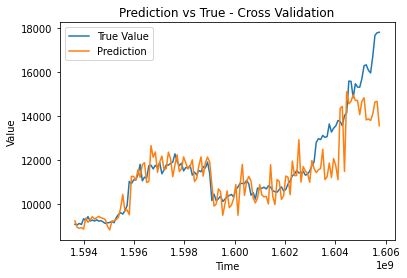

In [18]:
y_predict = [val.prediction for val in cvYhat.select('prediction').collect()]
y_true = [val.Target for val in cvYhat.select('Target').collect()]
x = [val.time for val in cvYhat.select('time').collect()]

plt.plot(x, y_true, label='True Value')
plt.plot(x, y_predict, label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('Prediction vs True - Cross Validation')
plt.legend()

plt.show()

In [19]:
# Evaluations of Cross Validation
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(cvYhat)
print('RMSE is', rmse)
mae = eval.evaluate(cvYhat, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(cvYhat, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 973.8457284290117
MAE is 647.8165248226951
R² is 0.7584607173932414


# 3 Classification Model

## Data Processing

In [ ]:
df2 = pd.read_excel("btc17-21_day.xlsx",sheet_name="Day")
df2=sql.createDataFrame(df2) 
df2.show()

+----------+------------------+---------------+---------------+------------+-------------+---------+--------------+--------------+-------------+-------------+----------+----------+-----------+-----------+----------+--------+--------+
|      time|num_not_empty_hour|      nBits_day|      value_day|in_count_day|out_count_day|count_day|volume_btc_day|volume_usd_day|value_min_day|value_max_day|in_min_day|in_max_day|out_min_day|out_max_day| Next_time|    Open|   Close|
+----------+------------------+---------------+---------------+------------+-------------+---------+--------------+--------------+-------------+-------------+----------+----------+-----------+-----------+----------+--------+--------+
|1605744000|                24|120357045062433|237845975128673|      854333|       900212|   311061|       648.258| 1.157131272E7|            0|1738730017046|         1|      1026|          1|       3678|1605830400|17801.21|17824.13|
|1605657600|                24|140069288055771|293015947122925| 

In [ ]:
# Features engineering
from pyspark.sql import functions as F
df2 = (df2
    .withColumn('time', df2['time']+0)
    .withColumn('nBits', df2['nBits_day']/df2['count_day'])
    .withColumn('value', df2['value_day']+0)
    .withColumn('in_count', df2['in_count_day']+0)
    .withColumn('out_count', df2['out_count_day']+0)
    .withColumn('count', df2['count_day']+0)
    .withColumn('value_max', df2['value_max_day']+0)
    .withColumn('in_max', df2['in_max_day']+0)
    .withColumn('out_max', df2['out_max_day']+0)
    .withColumn('Open', df2['Open']+0)
    # .withColumn('value', df['value']/df['count'])
    .withColumn('Volume BTC', F.round(df2['volume_btc_day'], 5))
    .withColumn('Close', df2['Close']+0)
    )
df2 = (df2
    .select(
        F.col('time'), F.col('nBits'), F.col('value'), F.col('in_count'), F.col('out_count'), F.col('count'), F.col('value_max'), 
        F.col('in_max'), F.col('out_max'), F.col('Open'), F.col('Volume BTC'), F.col('Close').alias('Target'),
    )
    )
df2.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|  Target|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|
|1605484800| 3.869549543175676E8|361830361786069|  920102|   869288|311477|1900338360044|   984|   3641| 15975.9|   563.242|16722.99|
|1605398400|        3.86974771E8|159894568491318|  856957|   7

In [ ]:
df2 = (df2
       .withColumnRenamed('Target', 'Close')
       .withColumn('Target', F.when(F.col('Close')-F.col('Open') > 0, 1).otherwise(0))
      ) 
df2.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|   Close|Target|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|     1|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|     1|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|     1|
|1605484800| 3.869549543175676E8|361830361786069|  920102|   869288|311477|1900338360044|   984|   3641| 15975.9|   563.242|16722.99|     1|
|1605398400| 

In [ ]:
# Feature aggregation
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC'], outputCol="features")
df2 = assembler.transform(df2)
df2.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+--------------------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|   Close|Target|            features|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+--------------------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|     1|[1.605744E9,3.869...|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|     1|[1.6056576E9,3.86...|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|     1|[1.6055712E9,3.86...|
|1605484800| 3.8695495431756

In [ ]:
# Split data into training set and testing set
# 2020-10-20(1603234800)
# 2020-08-01(1596240000)
# 2020-07-01(1593561600)
X_train = df2.filter(F.col('time') < "1593561600")
X_test = df2.filter(F.col('time') > "1593561600")
X_test.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+--------------------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|   Close|Target|            features|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+--------------------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|     1|[1.605744E9,3.869...|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|     1|[1.6056576E9,3.86...|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|     1|[1.6055712E9,3.86...|
|1605484800| 3.8695495431756

## Logistic Regression Model

In [ ]:
from pyspark.ml.classification import *
logr = LogisticRegression(featuresCol = 'features', labelCol='Target', maxIter=2)
fitted_logr = logr.fit(X_train)
yhat_logr = (fitted_logr.transform(X_test))
yhat_logr.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|Target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     1|[0.15725430840473...|       0.0|[0.53923276175912...|
|     1|[0.12883882656672...|       0.0|[0.53216522521051...|
|     1|[0.23533146898702...|       0.0|[0.55856284446245...|
|     1|[0.11001165869377...|       0.0|[0.52747521021797...|
|     0|[0.22851119879308...|       0.0|[0.55688050232829...|
|     0|[0.20323267485902...|       0.0|[0.55063400833812...|
|     1|[0.12063528174273...|       0.0|[0.53012229879844...|
|     1|[-0.0277860811174...|       1.0|[0.49305392661731...|
|     1|[0.01138705592562...|       0.0|[0.50284673322132...|
|     0|[0.07445551391538...|       0.0|[0.51860528421522...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_logr))

Test Area Under ROC 0.4340336134453782


## Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Target', maxDepth = 3)
dtc.setSeed(12345678)
fitted_dtc = dtc.fit(X_train)
yhat_dtc = fitted_dtc.transform(X_test)
yhat_dtc.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+-------------+----------+--------------------+
|Target|rawPrediction|prediction|         probability|
+------+-------------+----------+--------------------+
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     0|[147.0,170.0]|       1.0|[0.46372239747634...|
|     0|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     0|[147.0,170.0]|       1.0|[0.46372239747634...|
+------+-------------+----------+--------------------+
only showing top 10 rows



In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_dtc))

Test Area Under ROC 0.5090336134453781


## Gradient Boosted Tree Classifier

In [ ]:
# Applying a gradient boosted tree Classifier
gbtc = GBTClassifier(labelCol="Target")
gbtc.setSeed(123456)
fitted = gbtc.fit(X_train)
yhat_gbtc = (fitted.transform(X_test))
yhat_gbtc.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|Target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     1|[0.64473899284683...|       0.0|[0.78405881973456...|
|     1|[1.38064700728253...|       0.0|[0.94054803325580...|
|     1|[0.42817974208620...|       0.0|[0.70189948551258...|
|     1|[1.25223484980127...|       0.0|[0.92445456910647...|
|     0|[0.63217634998476...|       0.0|[0.77977449073481...|
|     0|[-0.1487594302880...|       1.0|[0.42616413008084...|
|     1|[0.62903498613886...|       0.0|[0.77869368533976...|
|     1|[0.50679881023198...|       0.0|[0.73372361886596...|
|     1|[0.44224954863057...|       0.0|[0.70775367628114...|
|     0|[0.49425128241743...|       0.0|[0.72879204942423...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_gbtc))

Test Area Under ROC 0.5044117647058826


### Optimise the model with Kfold and GridSearch Method(GBT)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbtc.maxDepth, [2, 4, 6])
             .addGrid(gbtc.maxBins, [20, 60])
             .addGrid(gbtc.maxIter, [10, 20])
             .build())
cvc = CrossValidator(estimator=gbtc, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvc.setSeed(12345678)
cvcModel = cvc.fit(X_train)
yhat_cvc = cvcModel.transform(X_test)
yhat_cvc.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|Target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     1|[-0.2097244647630...|       1.0|[0.39664862397659...|
|     1|[0.18561825823369...|       0.0|[0.59175773058091...|
|     1|[0.18561825823369...|       0.0|[0.59175773058091...|
|     1|[0.30271554047080...|       0.0|[0.64689786673930...|
|     0|[-0.2458725405516...|       1.0|[0.37948255739484...|
|     0|[-0.2091573669567...|       1.0|[0.39692008975375...|
|     1|[0.11370140983021...|       0.0|[0.55660697636911...|
|     1|[-0.2097244647630...|       1.0|[0.39664862397659...|
|     1|[-0.2097244647630...|       1.0|[0.39664862397659...|
|     0|[0.11370140983021...|       0.0|[0.55660697636911...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_cvc))

Test Area Under ROC 0.48897058823529427
